In [1]:
from collections import defaultdict, Counter

import pandas as pd
import numpy as np

import intake
import xarray as xr
import nc_time_axis
import pyleoclim as pyleo
import cftime

In [2]:
catalog = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# loading in the ESM catalog from Google Cloud Platform

In [3]:
experiments = ['historical', 'piControl']
experiment_subset = catalog.df[catalog.df.experiment_id.isin(experiments)]

In [4]:
sources = [grp[0] for grp in experiment_subset.groupby('source_id') if len(grp[1].experiment_id.unique()) == 2]

In [5]:
source_sub = experiment_subset[experiment_subset.source_id.isin(sources)]

The last 3 steps above are important because they actively set up the catalog to return all CMIPs that include models that simulate both picontrol and historical data. After that, the variable 'sources' is created to narrow down the pandas df to only include picontrol/historical data, and then groups the data by source_id which is the title of the specific models being ran.

In [6]:
table = pd.pivot_table(source_sub,
                       values='member_id', index=['institution_id','experiment_id','source_id'],
                       columns=['variable_id'], aggfunc='count')

The Step above creates a pivot table from the df to help visualize what data we are dealing with. The pivot catagorizes the data in order of significance 1.) institution 2.) experiment 3.) source.
- code block below removes all columns with insufficient data (if => 35% null values) with 0s, as well as a sum column that represents that amount of times each simulation model ran for

In [7]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 20)  

table = table.dropna(axis='columns', thresh=int(.65*len(table))).fillna(value=0)
pd.concat([table, table.aggregate('sum', axis="columns").rename('total')], axis=1)

areacello   cl  cli  clivi  clt  \
institution_id experiment_id source_id                                         
AS-RCEC        historical    TaiESM1               1.0  2.0  2.0    2.0  3.0   
               piControl     TaiESM1               1.0  1.0  1.0    1.0  2.0   
AWI            historical    AWI-CM-1-1-MR         5.0  0.0  0.0    5.0  5.0   
                             AWI-ESM-1-1-LR        0.0  1.0  1.0    1.0  2.0   
               piControl     AWI-CM-1-1-MR         1.0  0.0  0.0    1.0  0.0   
...                                                ...  ...  ...    ...  ...   
SNU            piControl     SAM0-UNICON           1.0  1.0  1.0    1.0  1.0   
THU            historical    CIESM                 3.0  3.0  3.0    3.0  2.0   
               piControl     CIESM                 1.0  1.0  1.0    1.0  1.0   
UA             historical    MCM-UA-1-0            2.0  2.0  0.0    0.0  0.0   
               piControl     MCM-UA-1-0            1.0  1.0  0.0    0.0  0.0   

                                             clw  clwvi  evspsbl  evspsblsoi  \
institution_id experiment_id source_id                                         
AS-RCEC        historical    TaiESM1         2.0    2.0      2.0         1.0   
               piControl     TaiESM1         1.0    1.0      1.0         1.0   
AWI            historical    AWI-CM-1-1-MR   0.0    5.0      5.0         0.0   
                             AWI-ESM-1-1-LR  1.0    1.0      1.0         0.0   
               piControl     AWI-CM-1-1-MR   0.0    1.0      1.0         0.0   
...                                          ...    ...      ...         ...   
SNU            piControl     SAM0-UNICON     1.0    1.0      1.0         1.0   
THU            historical    CIESM           3.0    3.0      0.0         3.0   
               piControl     CIESM           1.0    1.0      0.0         1.0   
UA             historical    MCM-UA-1-0      0.0    0.0      2.0         0.0   
               piControl     MCM-UA-1-0      0.0    0.0      1.0         0.0   

                                             evspsblveg  hfds  hfls  hfss  \
institution_id experiment_id source_id                                      
AS-RCEC        historical    TaiESM1                2.0   1.0   2.0   2.0   
               piControl     TaiESM1                1.0   1.0   2.0   2.0   
AWI            historical    AWI-CM-1-1-MR          0.0   5.0   5.0   5.0   
                             AWI-ESM-1-1-LR         0.0   1.0   2.0   2.0   
               piControl     AWI-CM-1-1-MR          0.0   1.0   1.0   1.0   
...                                                 ...   ...   ...   ...   
SNU            piControl     SAM0-UNICON            1.0   1.0   1.0   1.0   
THU            historical    CIESM                  3.0   3.0   3.0   3.0   
               piControl     CIESM                  1.0   1.0   1.0   1.0   
UA             historical    MCM-UA-1-0             0.0   2.0   2.0   2.0   
               piControl     MCM-UA-1-0             0.0   1.0   1.0   1.0   

                                             hur  hurs  hus  huss  lai  mrro  \
institution_id experiment_id source_id                                         
AS-RCEC        historical    TaiESM1         4.0   1.0  3.0   4.0  2.0   2.0   
               piControl     TaiESM1         1.0   1.0  1.0   2.0  1.0   1.0   
AWI            historical    AWI-CM-1-1-MR   5.0   0.0  5.0   5.0  0.0   0.0   
                             AWI-ESM-1-1-LR  3.0   2.0  2.0   3.0  1.0   2.0   
               piControl     AWI-CM-1-1-MR   1.0   1.0  1.0   0.0  0.0   0.0   
...                                          ...   ...  ...   ...  ...   ...   
SNU            piControl     SAM0-UNICON     1.0   1.0  1.0   1.0  1.0   1.0   
THU            historical    CIESM           3.0   0.0  3.0   3.0  3.0   3.0   
               piControl     CIESM           1.0   0.0  1.0   1.0  1.0   1.0   
UA             historical    MCM-UA-1-0      2.0   2.0  2.0   2.0  0.0   2.0   
 

In [8]:
table.columns.values


array(['areacello', 'cl', 'cli', 'clivi', 'clt', 'clw', 'clwvi',
       'evspsbl', 'evspsblsoi', 'evspsblveg', 'hfds', 'hfls', 'hfss',
       'hur', 'hurs', 'hus', 'huss', 'lai', 'mrro', 'pr', 'prc', 'prsn',
       'prw', 'ps', 'psl', 'rlds', 'rlus', 'rlut', 'rlutcs', 'rsds',
       'rsdt', 'rsus', 'rsut', 'rsutcs', 'sfcWind', 'siconc', 'sisnthick',
       'sitemptop', 'sithick', 'siu', 'siv', 'so', 'sos', 'ta', 'tas',
       'tasmax', 'tasmin', 'tauu', 'tauuo', 'tauv', 'tauvo', 'thetao',
       'tos', 'tran', 'ts', 'ua', 'uas', 'uo', 'va', 'vas', 'vo', 'wap',
       'zg', 'zos'], dtype=object)

Now that we have the list of all the variables being recorded from the simulations, it's time to create the search query to actually get the files that we want to do load for analysis. For this project, we only want 'tas' (temperature at surface). I chose to only return 'r1i1p1f1' models to have consistent variables in the data. You can find information about the different id codes here: https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit

In [9]:
query = dict(source_id=sources, 
     experiment_id=experiments, 
     grid_label='gn', 
     variable_id='tas', 
     table_id='Amon',
     member_id='r1i1p1f1'
    )


In [10]:
result = catalog.search(**query)


In [142]:
# formatting the search results into a disctionary of keys which are the names of every simulation file

temp_dict = result.to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 
                                    'variant_label'], xarray_open_kwargs={'consolidated': True,'use_cftime':True, 
                                    'chunks':{}}, storage_options={'token': 'anon'})
temp_dict.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.MPI-M.ICON-ESM-LR.historical.Amon.gn', 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn', 'CMIP.AS-RCEC.TaiESM1.piControl.Amon.gn', 'CMIP.CCCma.CanESM5.piControl.Amon.gn', 'CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.gn', 'CMIP.UA.MCM-UA-1-0.piControl.Amon.gn', 'CMIP.BCC.BCC-CSM2-MR.piControl.Amon.gn', 'CMIP.UA.MCM-UA-1-0.historical.Amon.gn', 'CMIP.MIROC.MIROC6.historical.Amon.gn', 'CMIP.MOHC.HadGEM3-GC31-MM.piControl.Amon.gn', 'CMIP.NCC.NorESM2-MM.historical.Amon.gn', 'CMIP.BCC.BCC-ESM1.historical.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn', 'CMIP.FIO-QLNM.FIO-ESM-2-0.piControl.Amon.gn', 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.piControl.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G-CC.piControl.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.piControl.Amon.gn', 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-2-H.piControl.Amon.gn', 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn', 'CMIP.AWI.AWI-ESM-1-1-LR.piControl.Amon.gn', 'CMIP.NCC.NorCPM1.historical.Amon.gn', 'CM

In [159]:
for key, value in temp_dict.items():
    # print(key)
    if 'longitude' in value.dims and 'latitude' in value.dims:
        # Perform the renaming of dimensions
        value = value.swap_dims({'longitude': 'lon', 'latitude': 'lat'})
        
    # if 'longitude' in value.coords:
    #     value = value.rename_vara({'longitude': 'lon'})
    # if 'latitude' in value.coords:
    #     value = value.rename_vars({'latitude': 'lat'})
    temp_dict[key] = value

# because some files inconsistently use different words for longitude and latitude, you need to normalize all of the words to be the same
# to iteratively load them in the future

## next steps
### historical
- extract the historical simulations and compute GMST
- plot them (try xarray .plot func)
- bundle all of the GMST series together in a dataframe

### picontrol
- zero out time axis (look for examples)
- compute GMST
- plot
- bundle into a dataframe (GMST series)

### trend analysis
- apply trends.ipynb to picontrol and historical GMST
- plot on the same figure as LMR

In [163]:
# helpful code for some troubleshooting:
# for key, value in temp_dict.items():
#     print(value.coords)

hist_key = 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn'
hist_df = result[hist_key].df
hist_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,_data_format_
0,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710,zarr


In [164]:
# np.set_printoptions(threshold=np.inf)  # Set the threshold to infinity

hist_xarray = temp_dict[hist_key]
tas = hist_xarray['tas']
hist_xarray
# hist_xarray.dims

<xarray.Dataset>
Dimensions:         (lat: 192, bnds: 2, lon: 384, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
    height          float64 ...
  * lat             (lat) float64 -89.28 -88.36 -87.42 ... 87.42 88.36 89.28
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
  * time            (time) object 1915-01-16 12:00:00 ... 1959-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 422, 192, 384), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:   time
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-...
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amo...

In [165]:

lat_weights = np.cos(np.deg2rad(hist_xarray.lat))
lat_weights.name = "lat_weights"

# FOR THE CMIP6.CMIP.MPI-M.ICON-ESM-LR WHICH HAS ANNOYING DIMENSIONS 

# lat_values = hist_xarray.lat.values
# lat_data_array = xr.DataArray(lat_values, dims='lat')
# lon_values = hist_xarray.lon.values
# lon_data_array = xr.DataArray(lon_values, dims='lon')
# lat_weights = np.cos(np.deg2rad(lat_data_array))
# lat_weights.name = "lat_weights"

In [166]:
gmst_anomaly = hist_xarray['tas'] - hist_xarray['tas'].mean(dim='time')
gmst_anomaly_weighted = gmst_anomaly.weighted(lat_weights).mean(dim=['lon', 'lat'])
# gmst_anomaly_weighted = gmst_anomaly.weighted(lat_weights).mean(dim=['lat']) FOR THE CMIP6.CMIP.MPI-M.ICON-ESM-LR WHICH HAS ANNOYING DIMENSIONS 
gmst_anomaly_weighted = np.squeeze(gmst_anomaly_weighted)


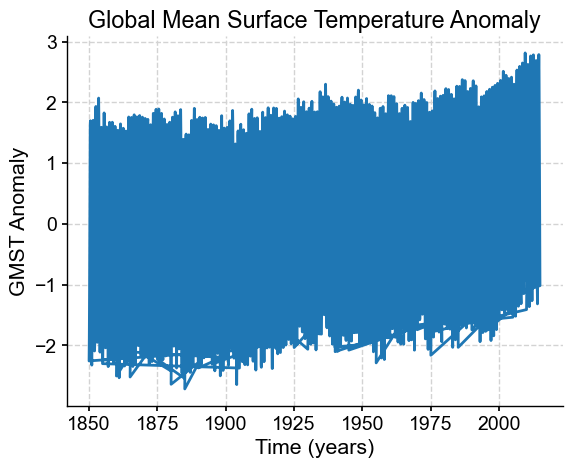

In [168]:
import matplotlib.pyplot as plt

time_float = cftime.date2num(hist_xarray.time.data,'months since 0-1-1', calendar='360_day', has_year_zero=True)/12
plt.plot(time_float, gmst_anomaly_weighted)
plt.xlabel('Time (years)')
plt.ylabel('GMST Anomaly')
plt.title('Global Mean Surface Temperature Anomaly')
plt.show()

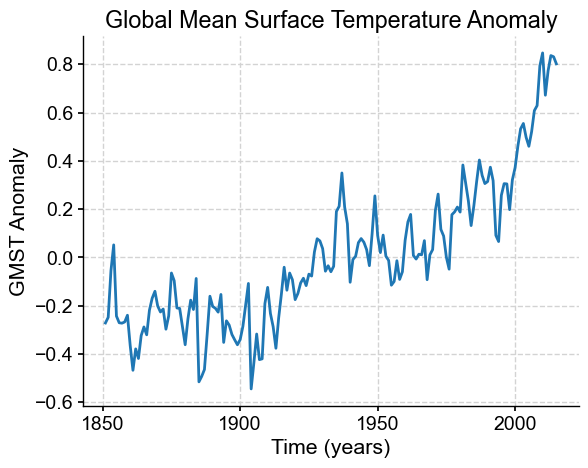

In [171]:
import matplotlib.pyplot as plt

lat_weights = np.cos(np.deg2rad(hist_xarray.lat))
lat_weights.name = "lat_weights"

# the following if statement is here because select datasets' time variable must fixed for monotonic increasing
if not hist_xarray.indexes['time'].is_monotonic_increasing:
    hist_xarray = hist_xarray.sortby('time')

gmst_anomaly = hist_xarray['tas'] - hist_xarray['tas'].mean(dim='time')
gmst_anomaly_weighted = gmst_anomaly.weighted(lat_weights).mean(('lon', 'lat'))
gmst_anomaly_weighted = np.squeeze(gmst_anomaly_weighted)

gmst_anomaly_yearly = gmst_anomaly_weighted.resample(time='Y').mean(dim='time')

time_years = gmst_anomaly_yearly['time']
plt.plot(time_years, gmst_anomaly_yearly)
plt.xlabel('Time (years)')
plt.ylabel('GMST Anomaly')
plt.title('Global Mean Surface Temperature Anomaly')
plt.show()

In [172]:
def plot_multiple_models(data_dict):
    fig, ax = plt.subplots()
    
    for key in data_dict.keys():
        if 'CMIP.MPI-M.ICON-ESM-LR' not in key:
            if 'historical' in key:
                print(key) #troubleshooting
                hist_xarray = data_dict[key]
                # print(hist_xarray.dims) troubleshooting

                # the following if statement is here because select datasets' time variable must fixed for monotonic increasing
                if not hist_xarray.indexes['time'].is_monotonic_increasing:
                    hist_xarray = hist_xarray.sortby('time')
                # Calculate GMST anomaly
                gmst_anomaly = hist_xarray['tas'] - hist_xarray['tas'].mean(dim='time')
                lat_weights = np.cos(np.deg2rad(hist_xarray.lat))
                gmst_anomaly_weighted = gmst_anomaly.weighted(lat_weights).mean(('lon', 'lat'))
                gmst_anomaly_weighted = np.squeeze(gmst_anomaly_weighted)
                gmst_anomaly_yearly = gmst_anomaly_weighted.resample(time='Y').mean(dim='time')
    
                # Plot GMST anomaly
                time_years = gmst_anomaly_yearly['time'].values.astype('datetime64[Y]')
                ax.plot(time_years, gmst_anomaly_yearly, label=key)
    
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('GMST Anomaly')
    ax.set_title('Global Mean Surface Temperature Anomaly')
    ax.legend()
    plt.show()

CMIP.NCAR.CESM2-WACCM.historical.Amon.gn
CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.gn
CMIP.UA.MCM-UA-1-0.historical.Amon.gn
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.NCC.NorESM2-MM.historical.Amon.gn
CMIP.BCC.BCC-ESM1.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn
CMIP.NCC.NorCPM1.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn
CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn
CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn
CMIP.CAS.FGOALS-g3.historical.Amon.gn
CMIP.AS-RCEC.TaiESM1.historical.Amon.gn
CMIP.SNU.SAM0-UNICON.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn
CMIP.NCAR.CESM2.historical.Amon.gn
CMIP.NCC.NorESM2-LM.historical.Amon.gn
CMIP.NCAR.CESM2-FV2.historical.Amon.gn
CMIP.CAS.CAS-ESM2-0.historical.Amon.gn
CMIP.NUIST.NESM3.historical.Amon.gn
CMIP.CSIRO.ACCESS-ESM1-5.hist

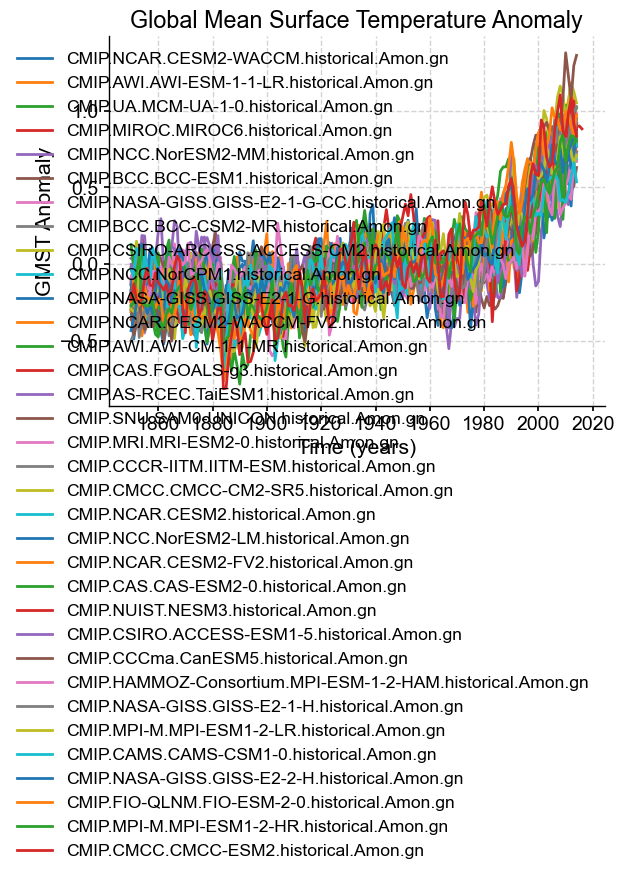

In [173]:
# Call the function with your data dictionary
plot_multiple_models(temp_dict)

In [186]:
gmst_anomaly_yearly_df = gmst_anomaly_yearly.to_dataframe()
gmst_anomaly_yearly_df.reset_index(inplace=True)  # Reset the index to access the 'time' variable
print(gmst_anomaly_yearly_df[['time', 'tas']])

                    time       tas
0    1850-12-31 00:00:00 -0.361675
1    1851-12-31 00:00:00 -0.321591
2    1852-12-31 00:00:00 -0.173217
3    1853-12-31 00:00:00 -0.046917
4    1854-12-31 00:00:00  0.064485
..                   ...       ...
160  2010-12-31 00:00:00  0.610851
161  2011-12-31 00:00:00  0.850319
162  2012-12-31 00:00:00  0.839170
163  2013-12-31 00:00:00  0.647890
164  2014-12-31 00:00:00  0.865086

[165 rows x 2 columns]


### now lets looks at piControl

In [20]:
picontrol_key = 'CMIP.CMCC.CMCC-CM2-SR5.piControl.Amon.gn'
picontrol_df = result[picontrol_key].df
picontrol_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,_data_format_
0,CMIP,CMCC,CMCC-CM2-SR5,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/piCont...,NaN,20200616,zarr


In [21]:
# np.set_printoptions(threshold=np.inf)  # Set the threshold to infinity

picontrol_xarray = temp_dict[picontrol_key]
tas_pi = picontrol_xarray['tas']
picontrol_xarray

<xarray.Dataset>
Dimensions:         (lat: 192, bnds: 2, lon: 288, member_id: 1,
                     dcpp_init_year: 1, time: 6000)
Coordinates:
    height          float64 ...
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 404, 192, 288), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5...
    intake_esm_attrs:version:         20200616
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CMCC.CMCC-CM2-SR5.piControl.Amon.gn

In [22]:
print(picontrol_xarray.time.values[0])

1850-01-16 12:00:00


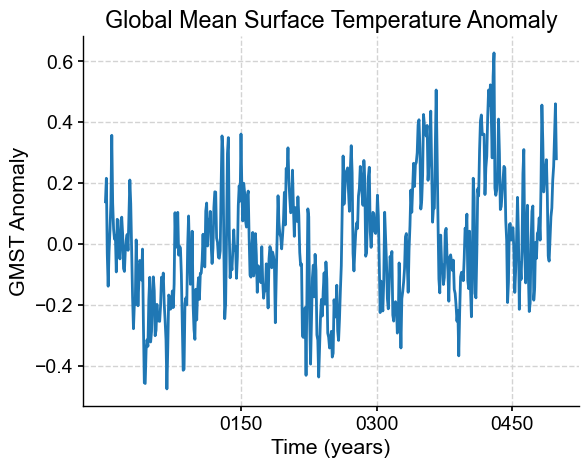

In [33]:
lat_weights_pi = np.cos(np.deg2rad(picontrol_xarray.lat))
lat_weights_pi.name = "lat_weights"

gmst_anomaly_pi = picontrol_xarray['tas'] - picontrol_xarray['tas'].mean(dim='time')
gmst_anomaly_weighted_pi = gmst_anomaly_pi.weighted(lat_weights_pi).mean(('lon', 'lat'))
gmst_anomaly_weighted_pi = np.squeeze(gmst_anomaly_weighted_pi)

gmst_anomaly_yearly_pi = gmst_anomaly_weighted_pi.resample(time='Y').mean(dim='time')

time_years_pi = gmst_anomaly_yearly_pi['time']
time_zeroed = xr.cftime_range(start='0000-01-01', periods=len(gmst_anomaly_yearly_pi['time']), freq='AS', calendar='proleptic_gregorian')
plt.plot(time_zeroed, gmst_anomaly_yearly_pi)
plt.xlabel('Time (years)')
plt.ylabel('GMST Anomaly')
plt.title('Global Mean Surface Temperature Anomaly')
plt.show()

In [24]:
def picontrol_times (temp_dict):
    for key in temp_dict.keys():
        if 'piControl' in key:
            temp_arr = temp_dict[key]
            print(temp_arr.time.values[0])


In [25]:
picontrol_times(temp_dict)

5201-01-16 12:00:00
0201-01-16 12:00:00
1850-01-16 12:00:00
0001-01-17 00:00:00
1850-01-16 00:00:00
0301-01-16 12:00:00
1850-01-16 12:00:00
1850-01-16 12:00:00
2000-01-16 12:00:00
1850-01-16 00:00:00
1200-01-16 12:00:00
1953-01-16 12:00:00
0001-01-15 12:00:00
0500-01-16 12:00:00
3180-01-16 12:00:00
0001-01-16 12:00:00
1850-01-16 12:00:00
1850-01-16 12:00:00
3200-01-16 12:00:00
0001-01-15 12:00:00
1850-01-16 12:00:00
0101-01-16 12:00:00
4000-01-16 12:00:00
0001-01-15 12:00:00
2900-01-16 12:00:00
1600-01-16 12:00:00
4150-01-16 12:00:00
1850-01-16 12:00:00
0001-01-15 12:00:00
1850-01-16 12:00:00
1926-01-16 12:00:00
0200-01-16 12:00:00
0001-01-16 12:00:00
1850-01-16 00:00:00
0001-01-16 12:00:00
2401-01-16 12:00:00
0950-01-16 12:00:00


In [177]:
def plot_multiple_models_pi(data_dict):
    fig, ax = plt.subplots()

    for key in data_dict.keys():
        if 'CMIP.MPI-M.ICON-ESM-LR' not in key:
            if 'piControl' in key:
                print(key)  # troubleshooting
                picontrol_xarray = data_dict[key]
                # print(hist_xarray.dims) troubleshooting

                # the following if statement is here because select datasets' time variable must be fixed for monotonic increasing
                if not picontrol_xarray.indexes['time'].is_monotonic_increasing:
                    picontrol_xarray = picontrol_xarray.sortby('time')

                lat_weights_pi = np.cos(np.deg2rad(picontrol_xarray.lat))
                lat_weights_pi.name = "lat_weights"

                gmst_anomaly_pi = picontrol_xarray['tas'] - picontrol_xarray['tas'].mean(dim='time')
                gmst_anomaly_weighted_pi = gmst_anomaly_pi.weighted(lat_weights_pi).mean(('lon', 'lat'))
                gmst_anomaly_weighted_pi = np.squeeze(gmst_anomaly_weighted_pi)

                gmst_anomaly_yearly_pi = gmst_anomaly_weighted_pi.resample(time='Y').mean(dim='time')

                time_years_pi = gmst_anomaly_yearly_pi['time']
                time_zeroed = xr.cftime_range(start='0000-01-01', periods=len(gmst_anomaly_yearly_pi['time']), freq='AS', calendar='proleptic_gregorian')

                ax.plot(time_zeroed, gmst_anomaly_yearly_pi, label=key)

    ax.set_xlabel('Time (years)')
    ax.set_ylabel('GMST Anomaly')
    ax.set_title('Global Mean Surface Temperature Anomaly')
    ax.legend()
    plt.show()

In [1]:
#plot_multiple_models_pi(temp_dict)